# loading libararies

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


# loading data set

In [2]:
y_df=pd.read_csv('./Train/train.csv')
print(y_df.head(7))

   ImageId NameOfPokemon
0  296.jpg       Pikachu
1  297.jpg       Pikachu
2  298.jpg       Pikachu
3  299.jpg       Pikachu
4  300.jpg       Pikachu
5  301.jpg       Pikachu
6  302.jpg       Pikachu


In [3]:
y_train=y_df.values
total_character=np.unique(y_train[:,1])
print(total_character)

['Bulbasaur' 'Charmander' 'Pikachu']


In [4]:
labels_dict={}
for i in range(total_character.shape[0]):
    labels_dict[total_character[i]]=i

In [5]:
print(labels_dict)

{'Bulbasaur': 0, 'Charmander': 1, 'Pikachu': 2}


In [21]:
a=y_df.NameOfPokemon[y_df['ImageId']=="398.jpg"].values[0]

In [22]:
print((a))

Bulbasaur


In [8]:
pi=Path("Train/Images/")

image_data=[]
labels=[]

for image_path in pi.glob("*.jpg"):
    
    label=(str(image_path).split("\\")[-1])
    name=y_df.NameOfPokemon[y_df['ImageId']==label].values[0]
    
    img=image.load_img(image_path,target_size=(32,32))
    image_array=image.img_to_array(img)
    image_data.append(image_array)
    labels.append(labels_dict[name])
    #print(name)

C:\Users\yash\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [23]:
len(image_data)

304

In [24]:
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)
print(image_data.shape,labels.shape)

(304, 32, 32, 3) (304,)


# visualizing data

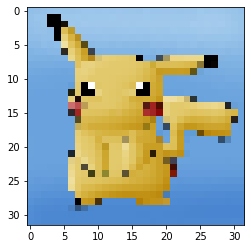

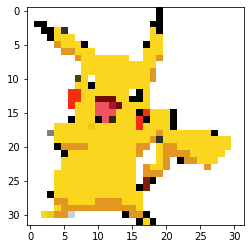

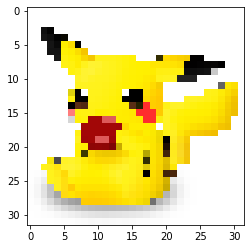

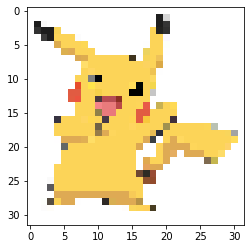

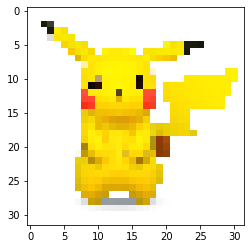

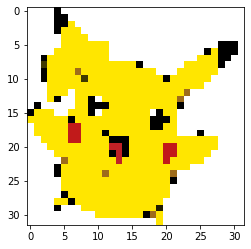

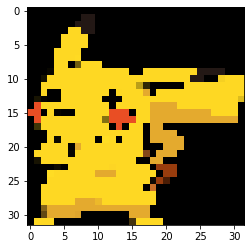

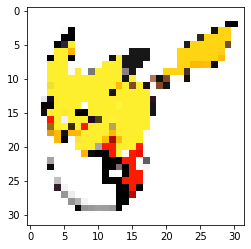

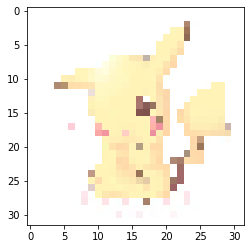

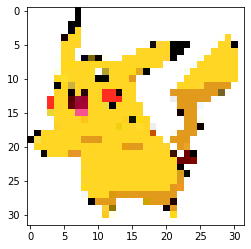

In [27]:
def drawimg(img):
    plt.imshow(img)
    plt.show()
    return

for i in range(10):
    drawimg(image_data[i])

# svm classifier

In [63]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C=1
        self.W=0
        self.b=0
        
    def hingeloss(self,W,b,X,Y):
        loss=0.0
        
        loss +=.5*np.dot(W,W.T)
        
        m=X.shape[0]
        
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T)+b)
            loss+=self.C*max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxitr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n=learning_rate
        c=self.C
        
        W=np.zeros((1,no_of_features))
        bias=0
        
        losses=[]
        
        for i in range(maxitr):
            
            l=self.hingeloss(W,bias,X,Y)
            losses.append(l)
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,batch_size):
                
                gradw = 0
                gradb = 0
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(W,X[i].T) + bias)
                        
                        if ti>1:
                            gradw+=0
                            gradb+=0
                        
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                        
                
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        self.W = W
        self.b = bias
            
        return W,bias,losses
                        
            
            
    
    

# we need to convert data for one-for -one clasificaition

In [64]:
M=image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(304, 3072)
(304,)


In [65]:
classes = len(np.unique(labels))
print(classes)

3


In [66]:
def classWiseData(x,y):
    data = {}
    
    for i in range(classes):
        data[i]=[]
    
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [67]:
data = classWiseData(image_data,labels)

In [68]:
print(data[0].shape)
print(data[1].shape[0])
print(data[2].shape[0])

(101, 3072)
102
101


In [69]:
def getdatapairforsvm(d1,d2):
    
    l1,l2=d1.shape[0],d2.shape[0]
    
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair  = np.zeros((samples,features))
    data_labels= np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels

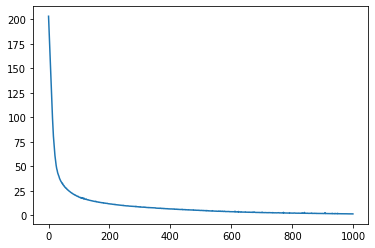

In [73]:
mySVM = SVM()
xp,yp = getdatapairforsvm(data[0],data[1])
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxitr=1000)
plt.plot(loss)

In [74]:
def trainSVMs(d):
    
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i]={}
        
        for j in range(i+1,classes):
            
            xpair,ypair=getdatapairforsvm(d[i],d[j])
            wts,b,loss=mySVM.fit(xpair,ypair,learning_rate=0.00001,maxitr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
    return svm_classifiers

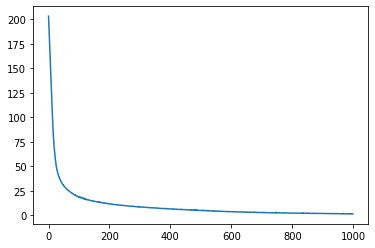

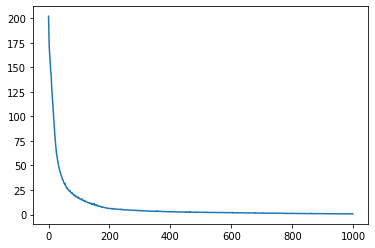

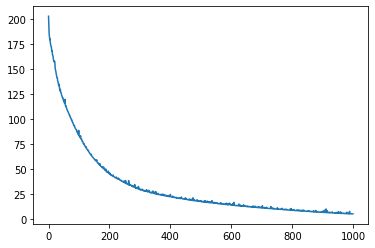

In [77]:
svm_classifiers = trainSVMs(data)

In [79]:
bulba_char = svm_classifiers[0][1]
bulba_pika = svm_classifiers[0][2]
print(bulba_char[0].shape)
print(bulba_char[1])

(1, 3072)
-0.003830000000000094


# predicition

In [80]:
def binaryPrediction(x,w,b):
    z = np.dot(x,w.T) + b
    if z>= 0:
        return 1
    else:
        return -1

In [81]:
def predict(x):
    
    count = np.zeros((classes,))
    
    for i in range(classes):
        
        for j in range(i+1,classes):
            w,b = svm_classifiers[i][j]
            
            z = binaryPrediction(x,w,b)
            
            if z==1:
                count[j] += 1
            
            else:
                count[i] += 1
    final_prediction = np.argmax(count)
    
    return final_prediction

In [84]:
print(predict(image_data[0]))
print(labels[0])

2
2


In [85]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [86]:
accuracy(image_data,labels)


1.0

# loading testing data

In [146]:
y_df_test=pd.read_csv('./Test/test.csv').values.reshape((-1,))
print((y_df_test.shape))

(123,)


In [136]:
pi_test=Path("Test/Images/")

image_data_test=[]
label_test=[]

for image_path in pi_test.glob("*.jpg"):
    
    label=(str(image_path).split("\\")[-1])
    
    img=image.load_img(image_path,target_size=(32,32))
    image_array=image.img_to_array(img)
    image_data_test.append(image_array)
    label_test.append(label)
    #print(name)

In [137]:
print(label_test[:5])

['1100.jpg', '1101.jpg', '1102.jpg', '1103.jpg', '1104.jpg']


In [138]:
image_data_test=np.array(image_data_test,dtype='float32')/255.0


In [139]:
print((label_test[0]))

1100.jpg


In [142]:
m=image_data_test.shape[0]

image_data_test = image_data_test.reshape(m,-1)
print(image_data_test.shape)
print(len(label_test))

(123, 3072)
123


In [143]:
new_labels_dict = {v:k for k,v in labels_dict.items()}

In [144]:
new_labels_dict

{0: 'Bulbasaur', 1: 'Charmander', 2: 'Pikachu'}

# getting prediction on test data

In [147]:
y_predict=[]
for i in range(image_data_test.shape[0]):
    index=label_test.index(y_df_test[i])
    y_pre=predict(image_data_test[index])
    name=new_labels_dict[y_pre]
    y_predict.append((y_df_test[i],name))

In [148]:
y_predict=np.array(y_predict)

In [149]:
y_predict[:,:]

array([['1106.jpg', 'Bulbasaur'],
       ['2236.jpg', 'Charmander'],
       ['1131.jpg', 'Bulbasaur'],
       ['2221.jpg', 'Charmander'],
       ['2011.jpg', 'Pikachu'],
       ['2030.jpg', 'Pikachu'],
       ['2035.jpg', 'Pikachu'],
       ['1110.jpg', 'Bulbasaur'],
       ['1104.jpg', 'Bulbasaur'],
       ['2217.jpg', 'Charmander'],
       ['1111.jpg', 'Bulbasaur'],
       ['1100.jpg', 'Bulbasaur'],
       ['1112.jpg', 'Bulbasaur'],
       ['1138.jpg', 'Bulbasaur'],
       ['2238.jpg', 'Charmander'],
       ['2009.jpg', 'Bulbasaur'],
       ['2225.jpg', 'Charmander'],
       ['2240.jpg', 'Charmander'],
       ['2020.jpg', 'Pikachu'],
       ['2209.jpg', 'Charmander'],
       ['2029.jpg', 'Pikachu'],
       ['1114.jpg', 'Bulbasaur'],
       ['2201.jpg', 'Charmander'],
       ['1118.jpg', 'Bulbasaur'],
       ['2025.jpg', 'Pikachu'],
       ['2202.jpg', 'Charmander'],
       ['1117.jpg', 'Bulbasaur'],
       ['1119.jpg', 'Bulbasaur'],
       ['2000.jpg', 'Pikachu'],
       ['2007.jpg',

In [150]:
df=pd.DataFrame(data=y_predict,columns=['ImageId','NameOfPokemon'])

In [151]:
df.head(7)

,ImageId,NameOfPokemon
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Charmander
4,2011.jpg,Pikachu
5,2030.jpg,Pikachu
6,2035.jpg,Pikachu


In [152]:
df.to_csv('y_prediction_of_pokemon.csv',index=False)